# Análisis de resultados electorales

Índice:
- [Armado de base](#armado)
- [Análisis](#analisis)

### Armado de base <a id='armado'></a>

In [1]:
import pandas as pd, numpy as np

Los resultados electorales provisorios de las elecciones generales de 2019 se encuentran para descargar en https://datos.gob.ar/dataset/otros-resultados-provisorios-elecciones-generales-2019

In [2]:
#cargamos archivos
mesas_totales_agrup = pd.read_csv('resultados-provisorios-generales-2019\mesas_agrp_politicas.dsv', sep='|',low_memory=False)
mesas_totales = pd.read_csv('resultados-provisorios-generales-2019\mesas_totales.dsv', sep='|',low_memory=False)
postulaciones = pd.read_csv('resultados-provisorios-generales-2019\descripcion_postulaciones.dsv', sep='|',low_memory=False)
regiones = pd.read_csv('resultados-provisorios-generales-2019\descripcion_regiones.dsv', sep='|',low_memory=False)
regiones['CODIGO_REGION']=regiones.CODIGO_REGION.apply(lambda x: int(x) if (len(x)==2) else x)
regiones.NOMBRE_REGION.replace('Ciudad Autónoma de Buenos Aires','CABA',inplace=True)

Creamos tablas con resultados presidenciales. Categoría de elecciones presidenciales es "100000000000". Dejamos una línea por mesa.

In [3]:
#votos en general
votos = mesas_totales[mesas_totales['CODIGO_CATEGORIA']==100000000000]\
.pivot_table(index=['CODIGO_DISTRITO','CODIGO_SECCION','CODIGO_CIRCUITO', 'CODIGO_MESA'],
             columns='CONTADOR', values='VALOR').reset_index()

#votos a partidos
votos_partidos = mesas_totales_agrup[mesas_totales_agrup['CODIGO_CATEGORIA']==100000000000]\
.pivot_table(index=['CODIGO_DISTRITO','CODIGO_SECCION','CODIGO_CIRCUITO', 'CODIGO_MESA'],
             columns='CODIGO_AGRUPACION', values='VOTOS_AGRUPACION').reset_index()

In [4]:
#unión
df=votos_partidos.merge(votos[['CODIGO_MESA','CSDU', 'Cantidad de Sobres Cubierta del Comando Electoral',
       'NOMINATION_SUBTOTAL', 'Total de electores de mesas computadas',
       'Total de votos afirmativos', 'Voto Recurrido', 'Voto blanco',
       'Voto nulo', 'Votos identidad impugnada']], on='CODIGO_MESA', how='outer')

#pegamos el nombre de la región
df=pd.merge(df, regiones, left_on='CODIGO_DISTRITO',right_on='CODIGO_REGION',how='left').drop('CODIGO_REGION', axis=1)

Confirmamos que la categoria de presidente es la dicha anteriormente. Vemos cuáles son los códigos de agrupación.

In [5]:
display(postulaciones.loc[postulaciones['CODIGO_CATEGORIA']==100000000000,'NOMBRE_CATEGORIA'].unique(),
       postulaciones.loc[postulaciones['CODIGO_CATEGORIA']==100000000000,['CODIGO_AGRUPACION', 'NOMBRE_AGRUPACION']])

array(['Presidente y Vicepresidente de la República'], dtype=object)

,CODIGO_AGRUPACION,NOMBRE_AGRUPACION
503,135,JUNTOS POR EL CAMBIO
504,131,FRENTE NOS
505,136,FRENTE DE TODOS
506,133,FRENTE DE IZQUIERDA Y DE TRABAJADORES - UNIDAD
507,137,CONSENSO FEDERAL
508,87,UNITE POR LA LIBERTAD Y LA DIGNIDAD


In [6]:
print('Misma cantidad de mesas en votos y votos a partidos: ',len(votos) == len(votos_partidos) == len(df))

Misma cantidad de mesas en votos y votos a partidos:  True


Creamos diccionario entre código y nombre de agrupación.

In [7]:
keys = list(postulaciones.loc[postulaciones['CODIGO_CATEGORIA']==100000000000,'CODIGO_AGRUPACION'])
values = list(postulaciones.loc[postulaciones['CODIGO_CATEGORIA']==100000000000,'NOMBRE_AGRUPACION'])
dic_agrupaciones=dict(zip(keys,values))
dic_agrupaciones

{'135': 'JUNTOS POR EL CAMBIO',
 '131': 'FRENTE NOS',
 '136': 'FRENTE DE TODOS',
 '133': 'FRENTE DE IZQUIERDA Y DE TRABAJADORES - UNIDAD',
 '137': 'CONSENSO FEDERAL',
 '87': 'UNITE POR LA LIBERTAD Y LA DIGNIDAD'}

In [8]:
df.rename(columns=dic_agrupaciones, inplace=True)

In [9]:
df.to_csv('resultados_generales_2019.csv', index=False)

### Análisis <a id='analisis'></a>

Seguimos tuit de [Franco Galeano](https://twitter.com/tartagalensis/status/1186790515553001476?s=21), que sigue ["el mapa de confiabilidad de las elecciones"](https://www.cippec.org/publicacion/mapa-de-confiabilidad-de-las-elecciones/) de CIPPEC. 

In [10]:
import pandas as pd, numpy as np, seaborn as sns
import matplotlib.pyplot as plt

El análisis forense electoral parte de la idea de que los votos se acumulan siguiendo una distribución normal. Acá las distribuciones de las dos principales fuerzas.

In [11]:
df['fdt_%']=df['FRENTE DE TODOS'] / df['Total de votos afirmativos']*100
df['jxc_%']=df['JUNTOS POR EL CAMBIO'] / df['Total de votos afirmativos']*100

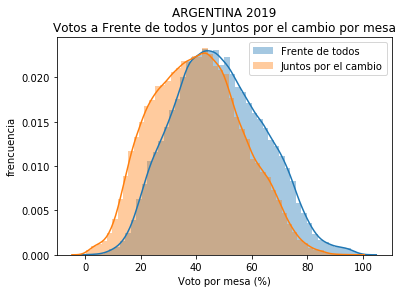

In [12]:
plot=df.copy()
plot.replace(0, np.nan, inplace=True)
plot.dropna(subset=['FRENTE DE TODOS','JUNTOS POR EL CAMBIO','Total de votos afirmativos'], inplace=True)

sns.distplot(plot['fdt_%'])
sns.distplot(plot['jxc_%'])
plt.title('ARGENTINA 2019\nVotos a Frente de todos y Juntos por el cambio por mesa')
plt.legend(['Frente de todos','Juntos por el cambio'])
plt.ylabel('frencuencia')
plt.xlabel('Voto por mesa (%)');

Analizamos la distibución por provincia.

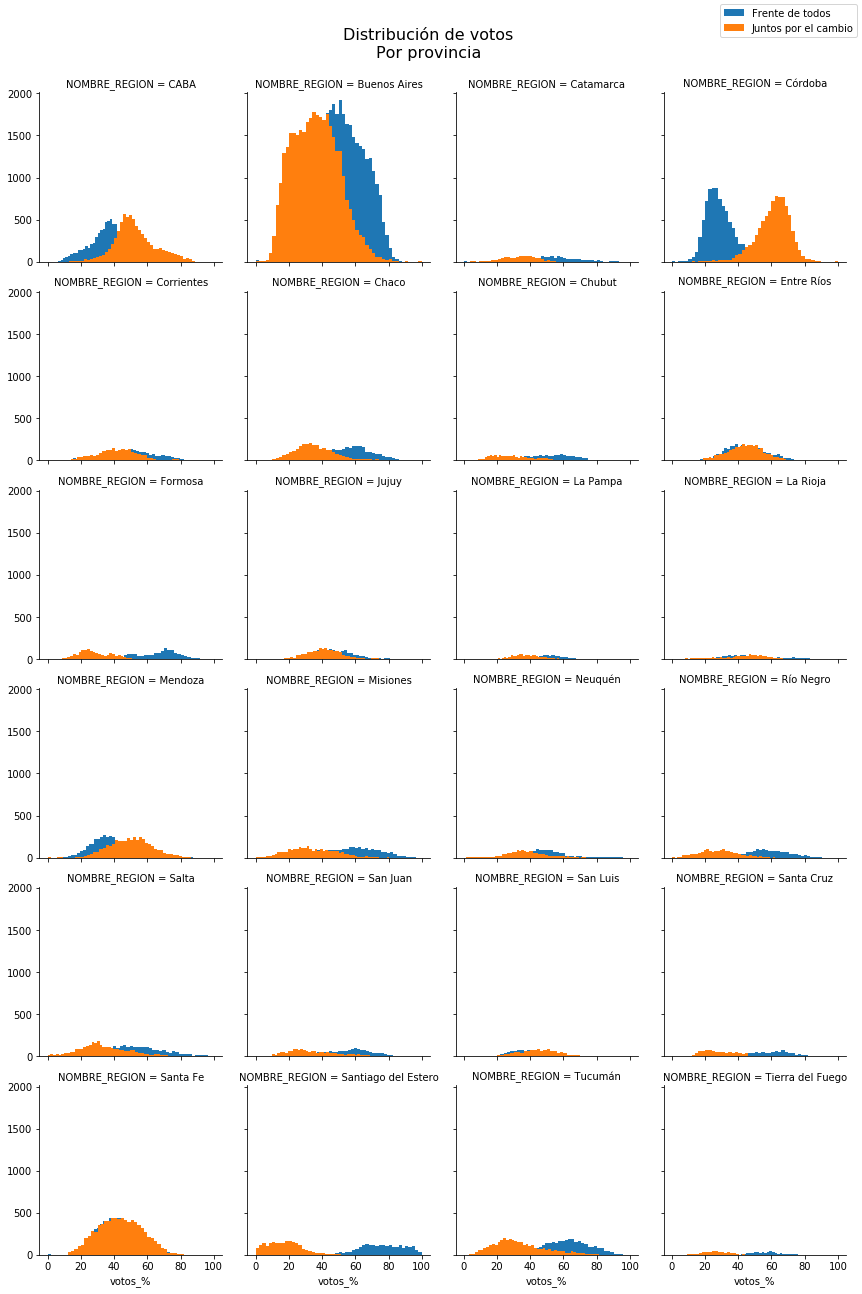

In [13]:
plot=df.melt(id_vars=['NOMBRE_REGION', 'CODIGO_MESA'], 
          value_vars=['fdt_%', 'jxc_%'],var_name='partido', value_name='votos_%')

g = sns.FacetGrid(plot, col="NOMBRE_REGION", col_wrap=4,hue='partido')
g = g.map(plt.hist, "votos_%", bins=50)

plt.subplots_adjust(top=0.93)
g.fig.suptitle('Distribución de votos\nPor provincia',
              fontsize=16)
g.fig.legend(['Frente de todos','Juntos por el cambio']);

Analizamos la distribución por provincia por separado, ya que puede haber outliers superpuestos.

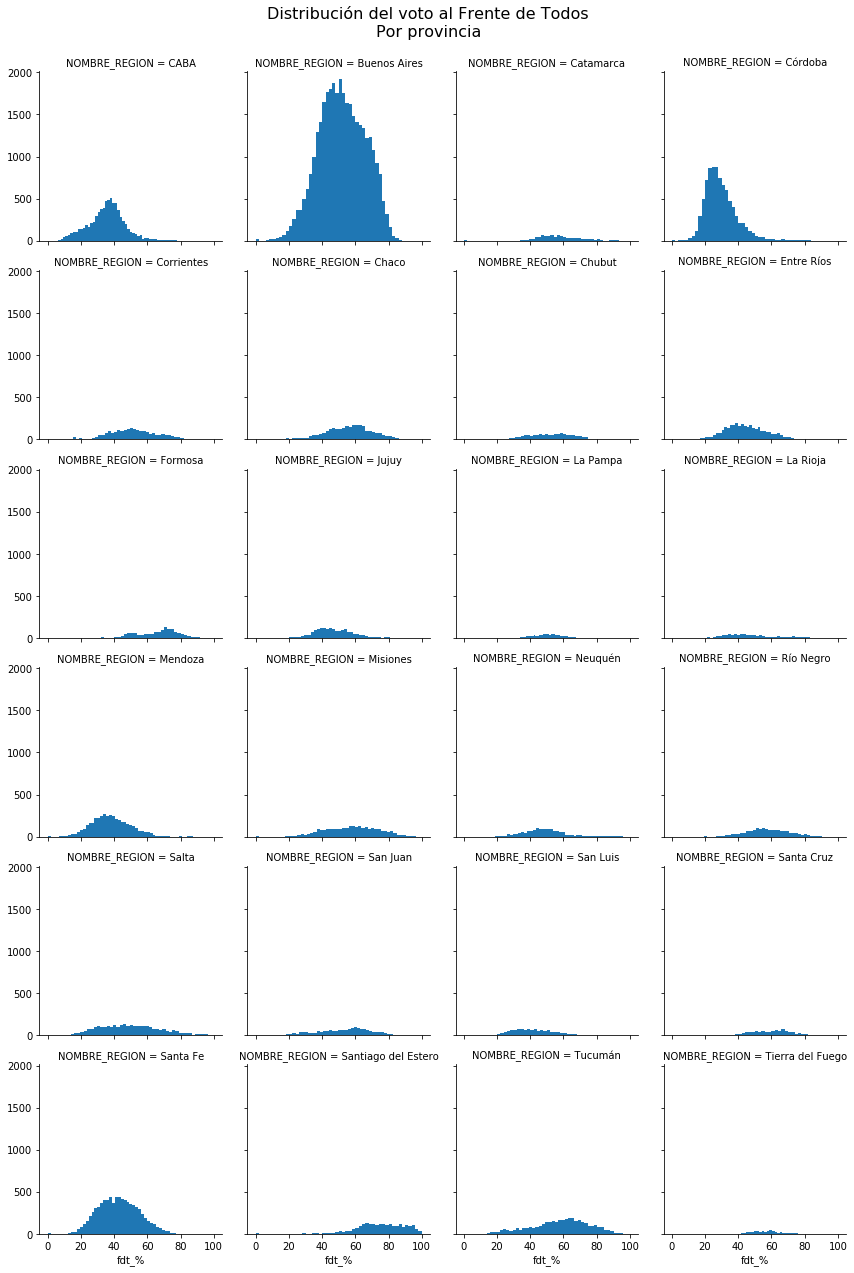

In [14]:
plot=df.copy()

g = sns.FacetGrid(plot, col="NOMBRE_REGION", col_wrap=4)
g = g.map(plt.hist, "fdt_%", bins=50)

plt.subplots_adjust(top=0.93)
g.fig.suptitle('Distribución del voto al Frente de Todos\nPor provincia',
              fontsize=16);

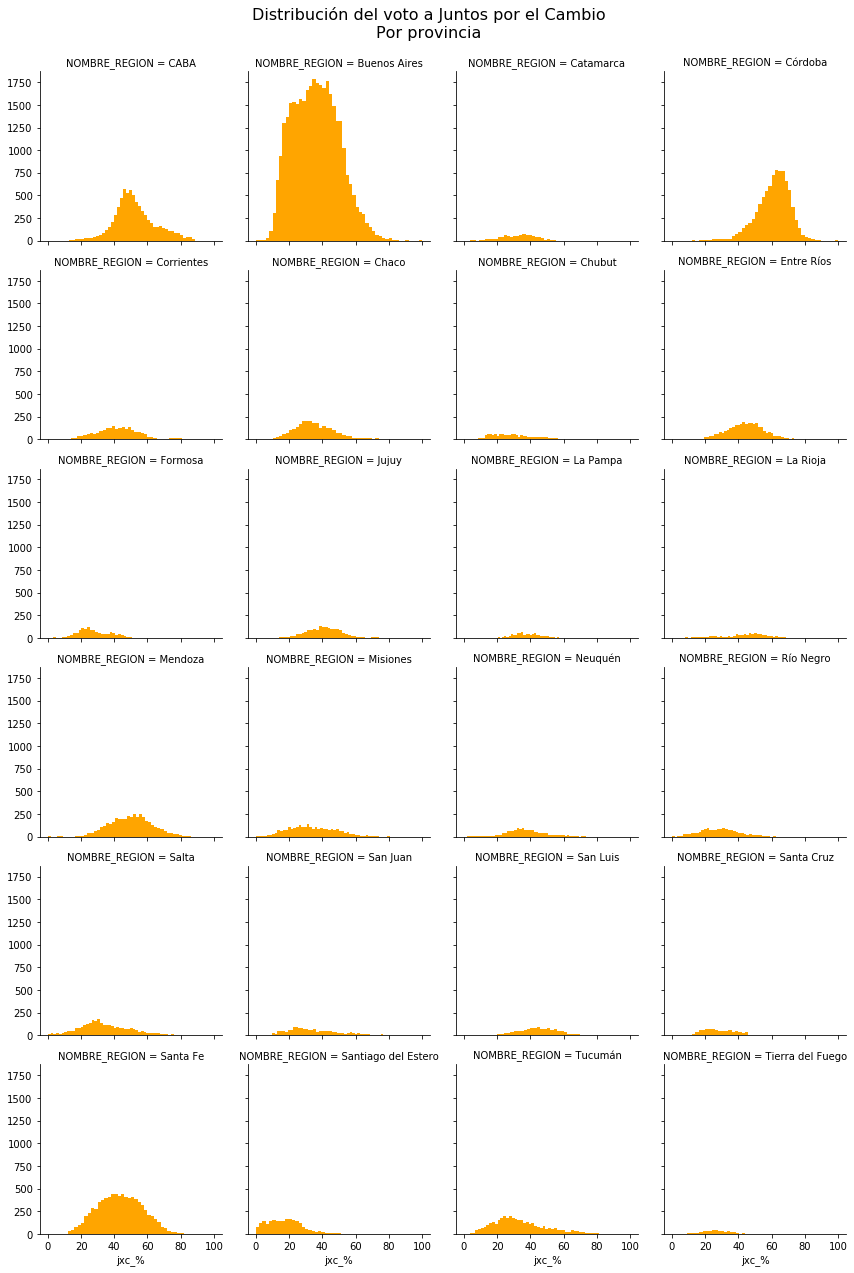

In [15]:
g = sns.FacetGrid(plot, col="NOMBRE_REGION", col_wrap=4)
g = g.map(plt.hist, "jxc_%", bins=50, color='orange')

plt.subplots_adjust(top=0.93)
g.fig.suptitle('Distribución del voto a Juntos por el Cambio\nPor provincia',
              fontsize=16);

Otro análisis posible es ver la correlación entre la participación y el desempeño de la lista más votada. La correlación sugeriría irregularidades.

In [16]:
df['participacion']=df['Total de votos afirmativos']/df['Total de electores de mesas computadas']*100

''

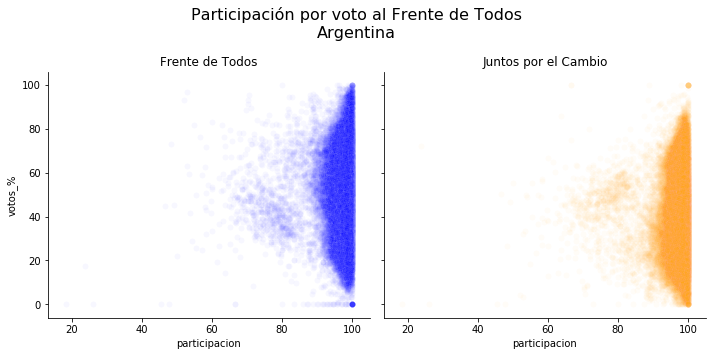

In [57]:
#data #puede tardar un poco por la cantidad de puntos
plot=df.melt(id_vars=['NOMBRE_REGION', 'CODIGO_MESA','participacion'], 
          value_vars=['fdt_%', 'jxc_%'],var_name='partido', value_name='votos_%')

d = {'color': ['b', 'orange']}

g = sns.FacetGrid(plot, col="partido", hue='partido',col_wrap=2,height=5, hue_kws=d)
g = g.map(sns.scatterplot,'participacion','votos_%', alpha=0.03)

plt.subplots_adjust(top=0.8)
g.fig.suptitle('Participación por voto al Frente de Todos\nArgentina',
              fontsize=16)
g.axes[0].set_title('Frente de Todos')
g.axes[1].set_title('Juntos por el Cambio')


;

''

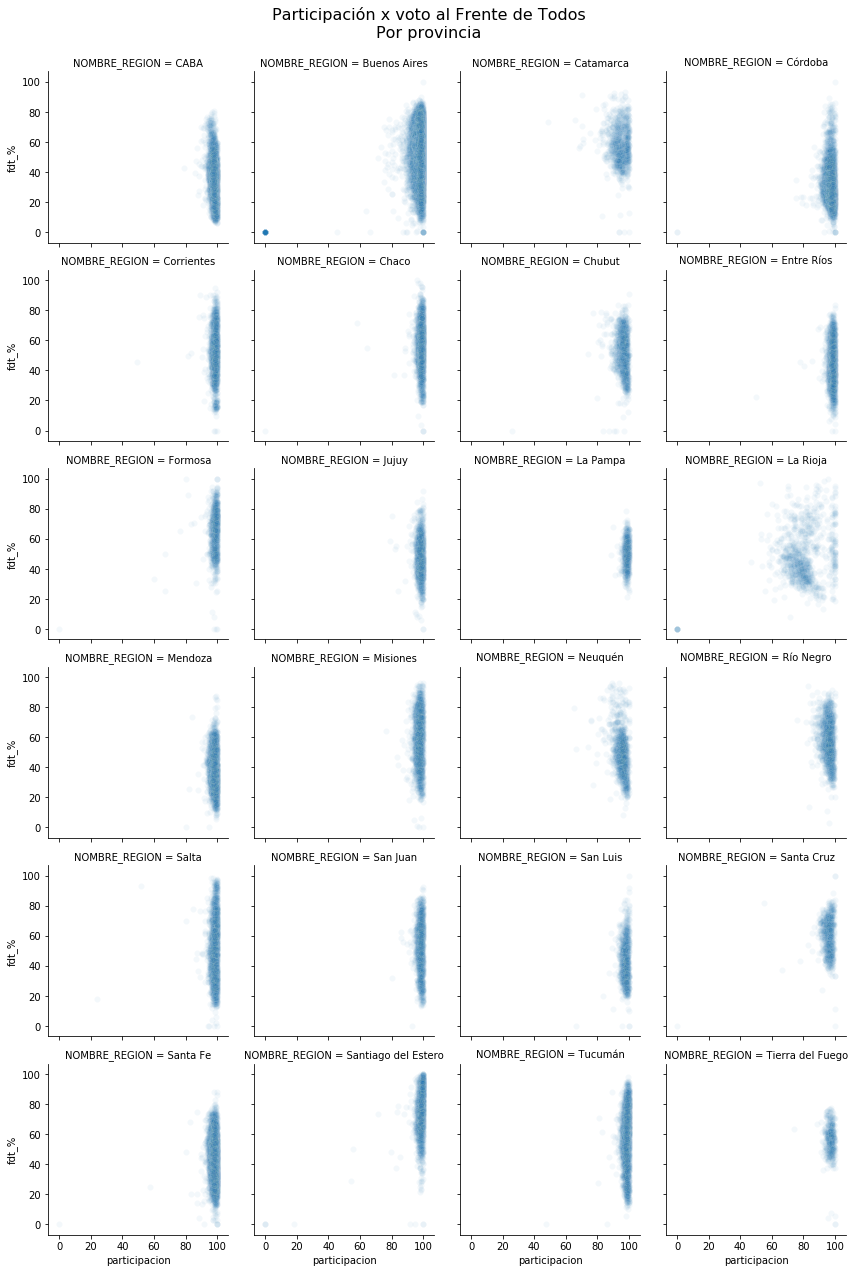

In [27]:
#data
plot=df.copy()
plot.fillna(0, inplace=True)

g = sns.FacetGrid(plot, col="NOMBRE_REGION", col_wrap=4)
g = g.map(sns.scatterplot,'participacion','fdt_%',alpha=0.05)

plt.subplots_adjust(top=0.93)
g.fig.suptitle('Participación x voto al Frente de Todos\nPor provincia',
              fontsize=16)
;

''

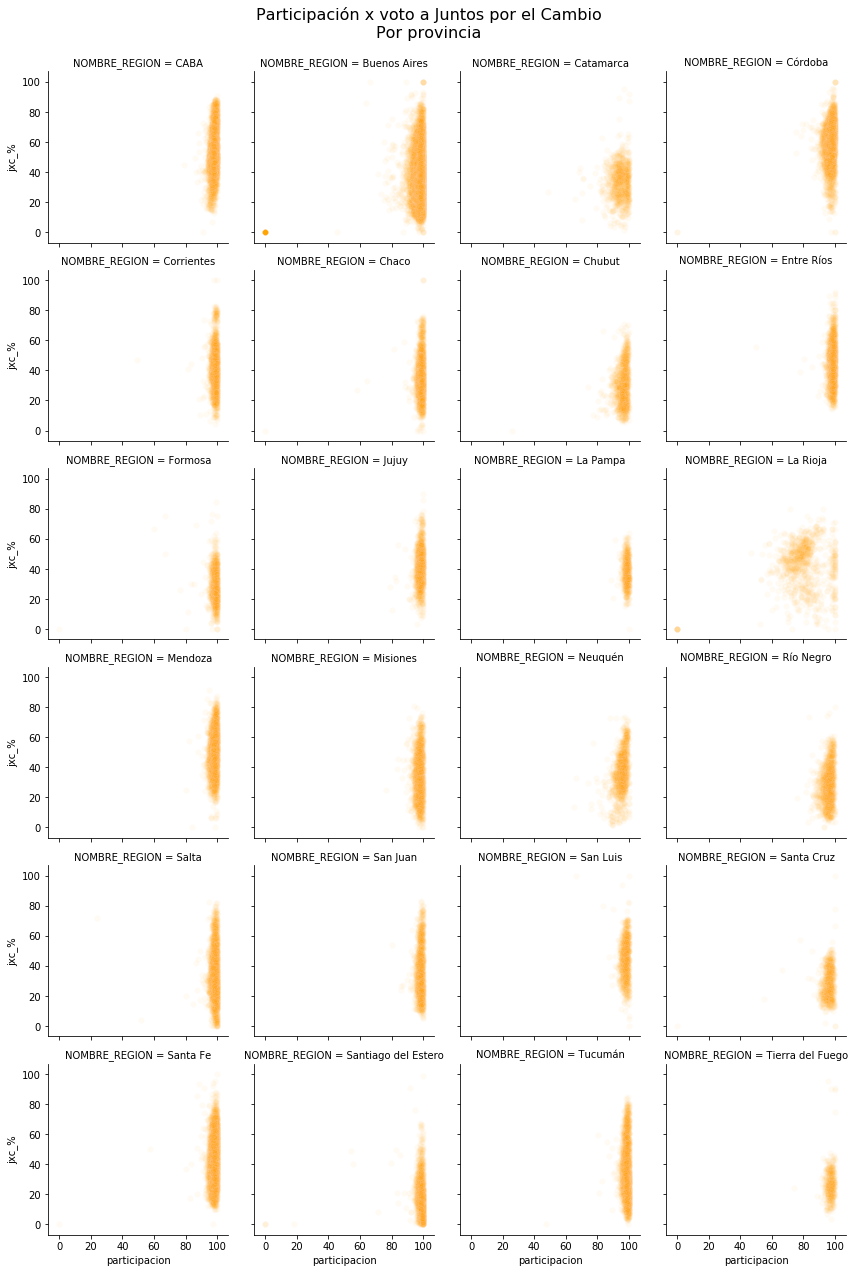

In [28]:
g = sns.FacetGrid(plot, col="NOMBRE_REGION", col_wrap=4)
g = g.map(sns.scatterplot,'participacion','jxc_%',color='orange',alpha=0.05)

plt.subplots_adjust(top=0.93)
g.fig.suptitle('Participación x voto a Juntos por el Cambio\nPor provincia',
              fontsize=16)
;